In [1]:
# Import Necessary Modules

import glob
import matplotlib.pyplot as plt 
from skimage import io
import numpy as np
%matplotlib inline 

In [2]:
#This function reads in all n images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get a data matrix
#X of size n x 4096. We also generate a -1 label if the row vector corresponds
#to a cat image and a +1 label if the row vector corresponds to a dog image
#and stack these on top of one another to get a label vector y of length n.

def read_data():
    
    #get image filenames
    cat_locs = glob.glob('catsfolder/*.jpg')
    dog_locs = glob.glob('dogsfolder/*.jpg')
    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)

    #initialize empty arrays
    X_cats = np.zeros((num_cats,64*64))
    X_dogs = np.zeros((num_dogs,64*64))
    y_cats = np.zeros((num_cats,1))
    y_dogs = np.zeros((num_dogs,1))
               
    #Load data, reshape into a 1D vector and set labels
    
    keep_track = 0

    for i in range(len(cat_locs)):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_cats[i,:] = im
        y_cats[i] = -1.0
        keep_track += 1

    for i in range(len(dog_locs)):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_dogs[i,:] = im
        y_dogs[i] = 1.0
        keep_track += 1
    
    # combine both datasets
    X = np.append(X_cats,X_dogs,0)
    y = np.append(y_cats,y_dogs)
    
    return X, y 

In [3]:
#This function takes in an n x 4096 data matrix X and an index i. It extracts
#the ith row of X and displays it as a grayscale 64 x 64 image.

def show_image(X, i):
    #select image
    image = X[i,:]
    #reshape make into a square
    image = image.reshape((64,64))
    #display the image
    plt.imshow(image,'gray')

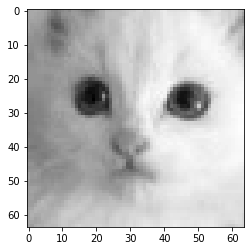

In [4]:
#Test to see if read_data and show_image working
X,y = read_data()
show_image(X,606)

In [5]:
#This function takes in a vector of true labels ytrue
#and a vector of guessed labels yguess and reports back
#the accuracy of the guesses out of 100%.

def calculate_accuracy(ytrue, yguess):
    
    # compare your predictions with the correct labels to determine how many of your predictions were correct.
    correct = sum((ytrue == yguess))
    total = len(ytrue)
    accuracy = 100*float(correct)/float(total)
    # divide the number of correct predictions by the number of total samples to determine your classification accuracy.
    return accuracy

In [6]:
#This function takes in a data matrix X, label vector y, and 
#the desired percentage testpercent. It randomly assigns  
#testpercent of the rows of X and y to Xtest and ytest. 
#The remaining data is assigned to Xtrain and ytrain.

def split_data(X,y,testpercent):
        
    [n, d] = X.shape
    
    ntest = int(round(n*(float(testpercent)/100)))
    ntrain = int(round(n - ntest))
        
    Xtrain = np.zeros((ntrain,d))
    Xtest = np.zeros((ntest,d))
    ytrain = np.zeros((ntrain,1))
    ytest = np.zeros((ntest,1))   
        
    Data = np.column_stack((X,y))
    Data = np.random.permutation(Data)
    
    for i in range(ntest):
        Xtest[i,:] = Data[i,0:d]
        ytest[i] = Data[i,d]
        
    for i in range(ntrain):
        Xtrain[i,:] = Data[i+ntest,0:d]
        ytrain[i] = Data[i+ntest,d]
        
    return Xtrain, ytrain, Xtest, ytest

In [7]:
#This code implements the PCA exactly as in MATLAB so as to be consistent.
#It takes in an n x d data matrix X and returns a d x d orthonormal matrix pcaX. 
#Each column of pcaX contains a basis vector, sorted by decreasing variance.

def pca(X):
    covX = np.cov(X,rowvar=False)
    [Lambda,Vtranspose] = np.linalg.eig(covX)
    neworder = np.argsort(-abs(Lambda))
    pcaX = Vtranspose[:,neworder]
    pcaX = pcaX.real
    return pcaX

In [8]:
#This function takes in a data matrix X and a label
#vector y and outputs the average cat image and average dog image.

def average_pet(X,y):
    
    #initialize length 4096 row vector, each row represents a pixel
    avgcat = np.zeros((1,4096))
    avgdog = np.zeros((1,4096))

    countcat = 0
    countdog = 0

    for init, tag in zip(X,y):
        #iterate thruough both X and y
        if tag == -1: #if tag was -1 add to cat vector and increment how many cats have been encountered
            avgcat += init
            countcat += 1
        elif tag == 1: #if tag was 1 add to dog vector and increment how many dogs have been encountered
            avgdog += init
            countdog += 1

    avgcat = np.divide(avgcat,countcat)
    avgdog = np.divide(avgdog,countdog)

    return avgcat, avgdog

Average cat:


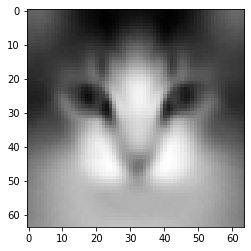

In [9]:
X,y = read_data()

averagecat, averagedog = average_pet(X,y)

print("Average cat:")
show_image(averagecat,0)

Average dog:


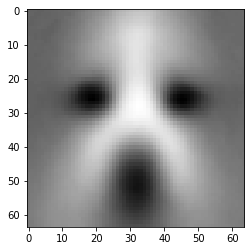

In [10]:
X,y = read_data()

averagecat, averagedog = average_pet(X,y)

print("Average dog:")
show_image(averagedog,0)

In [11]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to whether
#each row of Xtest is closer to the average cat or average dog.

def closest_average(Xtrain,ytrain,Xrun):
    
    #initialize length 4096 row vector, each row represents a pixel
    avgcat = np.zeros((1,4096))
    avgdog = np.zeros((1,4096))

    countcat = 0
    countdog = 0

    for init, tag in zip(Xtrain,ytrain):
        #iterate thruough both X and y
        if tag == -1: #if tag was -1 add to cat vector and increment how many cats have been encountered
            avgcat += init
            countcat += 1
        elif tag == 1: #if tag was 1 add to dog vector and increment how many dogs have been encountered
            avgdog += init
            countdog += 1

    avgcat = np.divide(avgcat,countcat)
    avgdog = np.divide(avgdog,countdog)
    
    #initialize vector for output
    yguess = np.zeros((len(Xrun), 1))

    #for each tag and value in Xrun, assign value to yguess at the specific index (i) to be either -1(cat) or 1(dog)

    for i, value in enumerate(Xrun):
        if np.linalg.norm(value - avgcat) > np.linalg.norm(value - avgdog):
            #if dog appears closer
            yguess[i] = 1
        elif np.linalg.norm(value - avgcat) <= np.linalg.norm(value - avgdog):
            #if cat appears closer
            yguess[i] = -1


    return yguess

In [12]:
X, y = read_data()
#split the data into train and test using given percentages

Xtrain, ytrain, Xtest, ytest = split_data(X,y,20)

#test closest_average with training data and Xtest 
yguess = closest_average(Xtrain, ytrain, Xtest)

accurateto = calculate_accuracy(ytest,yguess) #calculate accuracy of yguess
print('Accurate to what percentage for ytest using train as arguements 1 and 2, Xtest as argument 3: ')
print(accurateto)

#test closest_average with test data and Xtest
yguess2 = closest_average(Xtest, ytest, Xtest)

accurateto2 = calculate_accuracy(ytest,yguess2) #calculate accuracy of yguess2
print('Accurate to what percentage for ytest using test as arguement 1 and 2, Xtest as argument 3: ')
print(accurateto2)

#attempting to run these accuracy functions with ytrain returns errors because the size of yguess is determined by the size of XRun
#hence it is only compatible with the size of ytest. If one wishes to test these functions for Ytrain, they must pass Xtrain as the last 
#argument in closest_average

#test closest_average with training data and Xtrain 
yguess3 = closest_average(Xtrain, ytrain, Xtrain)

accurateto3 = calculate_accuracy(ytrain,yguess3) #calculate accuracy of yguess
print('Accurate to what percentage for ytrain using train as arguements 1 and 2, Xtrain as argument 3: ')
print(accurateto3)

#test closest_average with test data and Xtrain
yguess4 = closest_average(Xtest, ytest, Xtrain)

accurateto4 = calculate_accuracy(ytrain,yguess4) #calculate accuracy of yguess2
print('Accurate to what percentage for ytrain using test as arguement 1 and 2, Xtrain as argument 3: ')
print(accurateto4)

Accurate to what percentage for ytest using train as arguements 1 and 2, Xtest as argument 3: 
78.75
Accurate to what percentage for ytest using test as arguement 1 and 2, Xtest as argument 3: 
78.75
Accurate to what percentage for ytrain using train as arguements 1 and 2, Xtrain as argument 3: 
81.0625
Accurate to what percentage for ytrain using test as arguement 1 and 2, Xtrain as argument 3: 
79.125


In [13]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the average cat
#and dog vectors. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess. Each guess is found
#by searching through Xtrain to find the closest row, and then 
#outputting its label.

def nearest_neighbor(Xtrain,ytrain,Xrun):
    
    #initialize output vector
    yguess = np.zeros((len(Xrun), 1))

    #run through each datavalue of Xrun and assing values to yguess based on which 
    #Xtrainvalue has the closest euclidian distance 
    for index, datavalue in enumerate(Xrun):
        #set dist as an arbritarily large value for now so that the if statement 
        #in the forloop can run
        dist = 20012000100 #my birthday!
        for Xtrainvalue, tag in zip(Xtrain, ytrain):
            if np.linalg.norm(datavalue - Xtrainvalue) < dist:
                #if dist is bigger than current dist
                dist = np.linalg.norm(datavalue - Xtrainvalue) #update dist
                yguess[index] = tag #update tag at that index

    
    return yguess

In [14]:
X, y = read_data()
#split the data into train and test using given percentages

Xtrain, ytrain, Xtest, ytest = split_data(X,y,20)

#test nearest_neighbor with training data and Xtest 
yguess = nearest_neighbor(Xtrain, ytrain, Xtest)

accurateto = calculate_accuracy(ytest,yguess) #calculate accuracy of yguess
print('Accurate to what percentage for ytest using train as arguements 1 and 2, Xtest as argument 3: ')
print(accurateto)

#test nearest_neighbor with test data and Xtest
yguess2 = nearest_neighbor(Xtest, ytest, Xtest)

accurateto2 = calculate_accuracy(ytest,yguess2) #calculate accuracy of yguess2
print('Accurate to what percentage for ytest using test as arguement 1 and 2, Xtest as argument 3: ')
print(accurateto2)

#attempting to run these accuracy functions with ytrain returns errors because the size of yguess is determined by the size of XRun
#hence it is only compatible with the size of ytest. If one wishes to test these functions for Ytrain, they must pass Xtrain as the last 
#argument in nearest_neighbor

#test nearest_neighbor with training data and Xtrain 
yguess3 = nearest_neighbor(Xtrain, ytrain, Xtrain)

accurateto3 = calculate_accuracy(ytrain,yguess3) #calculate accuracy of yguess
print('Accurate to what percentage for ytrain using train as arguements 1 and 2, Xtrain as argument 3: ')
print(accurateto3)

#test nearest_neighbor with test data and Xtrain
yguess4 = nearest_neighbor(Xtest, ytest, Xtrain)

accurateto4 = calculate_accuracy(ytrain,yguess4) #calculate accuracy of yguess2
print('Accurate to what percentage for ytrain using test as arguement 1 and 2, Xtrain as argument 3: ')
print(accurateto4)

Accurate to what percentage for ytest using train as arguements 1 and 2, Xtest as argument 3: 
81.75
Accurate to what percentage for ytest using test as arguement 1 and 2, Xtest as argument 3: 
100.0
Accurate to what percentage for ytrain using train as arguements 1 and 2, Xtrain as argument 3: 
100.0
Accurate to what percentage for ytrain using test as arguement 1 and 2, Xtrain as argument 3: 
81.9375


In [15]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute ordinary-least-squares
#vector b. It also takes in a data matrix Xrun and 
#produces a vector of label guesses yguess, corresponding to the sign
#of the linear prediction.

def linear_regression(Xtrain,ytrain,Xrun):
    
    Xtrain_transposed = np.transpose(Xtrain) #trying to ease the nested function

    bols = np.matmul(np.matmul(np.linalg.pinv(np.matmul(Xtrain_transposed, Xtrain)), Xtrain_transposed), ytrain) #provided formula

    yguess = np.sign(np.matmul(Xrun,bols))
    
    return yguess

In [16]:
X, y = read_data()
#split the data into train and test using given percentages

Xtrain, ytrain, Xtest, ytest = split_data(X,y,20)

#test linear_regression with training data and Xtest 
yguess = linear_regression(Xtrain, ytrain, Xtest)

accurateto = calculate_accuracy(ytest,yguess) #calculate accuracy of yguess
print('Accurate to what percentage for ytest using train as arguements 1 and 2, Xtest as argument 3: ')
print(accurateto)

#test linear_regression with test data and Xtest
yguess2 = linear_regression(Xtest, ytest, Xtest)

accurateto2 = calculate_accuracy(ytest,yguess2) #calculate accuracy of yguess2
print('Accurate to what percentage for ytest using test as arguement 1 and 2, Xtest as argument 3: ')
print(accurateto2)

#attempting to run these accuracy functions with ytrain returns errors because the size of yguess is determined by the size of XRun
#hence it is only compatible with the size of ytest. If one wishes to test these functions for Ytrain, they must pass Xtrain as the last 
#argument in linear_regression

#test linear_regression with training data and Xtrain 
yguess3 = linear_regression(Xtrain, ytrain, Xtrain)

accurateto3 = calculate_accuracy(ytrain,yguess3) #calculate accuracy of yguess
print('Accurate to what percentage for ytrain using train as arguements 1 and 2, Xtrain as argument 3: ')
print(accurateto3)

#test linear_regression with test data and Xtrain
yguess4 = linear_regression(Xtest, ytest, Xtrain)

accurateto4 = calculate_accuracy(ytrain,yguess4) #calculate accuracy of yguess2
print('Accurate to what percentage for ytrain using test as arguement 1 and 2, Xtrain as argument 3: ')
print(accurateto4)

Accurate to what percentage for ytest using train as arguements 1 and 2, Xtest as argument 3: 
79.0
Accurate to what percentage for ytest using test as arguement 1 and 2, Xtest as argument 3: 
100.0
Accurate to what percentage for ytrain using train as arguements 1 and 2, Xtrain as argument 3: 
100.0
Accurate to what percentage for ytrain using test as arguement 1 and 2, Xtrain as argument 3: 
86.5625


Original image 1:


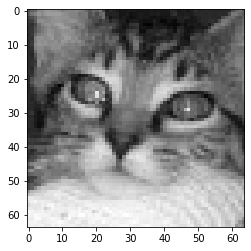

In [62]:
X, y = read_data()
#split the data into train and test using given percentages

Xtrain, ytrain, Xtest, ytest = split_data(X,y,20)

Xtrain_pca = pca(Xtrain)

#for output take the transpose 
Xtrain_pca_T = np.transpose(Xtrain_pca)

#print images using show image
print("Original image 1:")
show_image(Xtrain,1)

#The PCA images appear to be reduced version of each image yet they still reselmble the original image in some way 
#this shows that we have effectively simplified the images in the training matrix while not seamlessly throwing out pixels


PCA image 1:


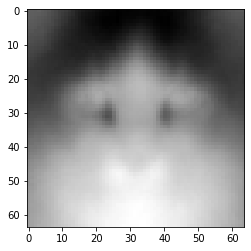

In [43]:
print("PCA image 1:")
show_image(Xtrain_pca_T,1)



Original image 2:


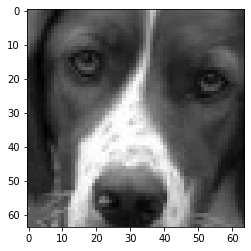

In [44]:
print("Original image 2:")
show_image(Xtrain,2)



PCA image 2:


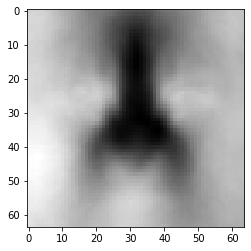

In [45]:
print("PCA image 2:")
show_image(Xtrain_pca_T,2)



Original image 3:


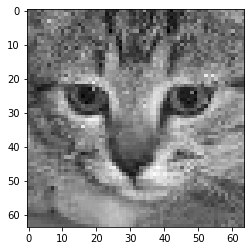

In [46]:
print("Original image 3:")
show_image(Xtrain,3)



PCA image 3:


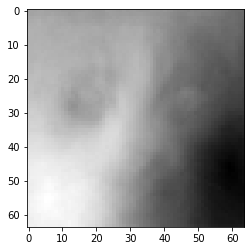

In [47]:
print("PCA image 3:")
show_image(Xtrain_pca_T,3)



Original image 4:


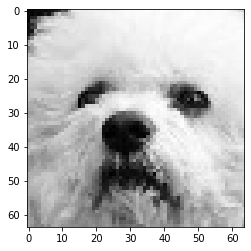

In [48]:
print("Original image 4:")
show_image(Xtrain,4)



PCA image 4:


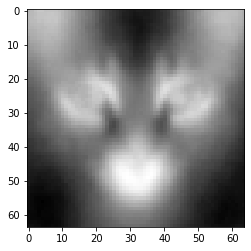

In [49]:
print("PCA image 4:")
show_image(Xtrain_pca_T,4)



Original image 5:


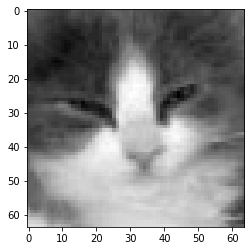

In [50]:
print("Original image 5:")
show_image(Xtrain,5)



PCA image 5:


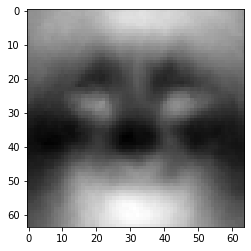

In [51]:
print("PCA image 5:")
show_image(Xtrain_pca_T,5)



Original image 6:


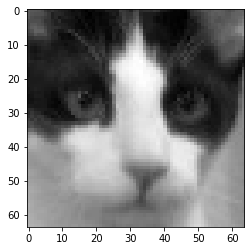

In [52]:
print("Original image 6:")
show_image(Xtrain,6)



PCA image 6:


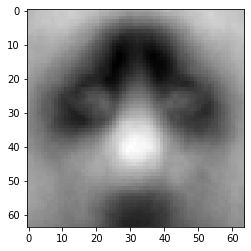

In [53]:
print("PCA image 6:")
show_image(Xtrain_pca_T,6)



Original image 7:


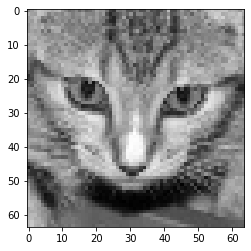

In [54]:
print("Original image 7:")
show_image(Xtrain,7)



PCA image 7:


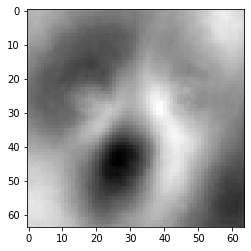

In [55]:
print("PCA image 7:")
show_image(Xtrain_pca_T,7)



Original image 8:


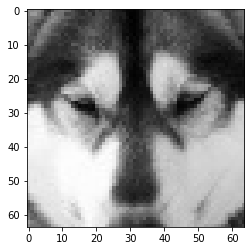

In [56]:
print("Original image 8:")
show_image(Xtrain,8)



PCA image 8:


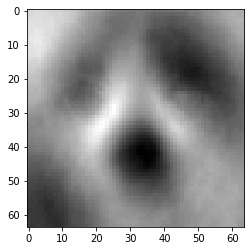

In [57]:
print("PCA image 8:")
show_image(Xtrain_pca_T,8)



Original image 9:


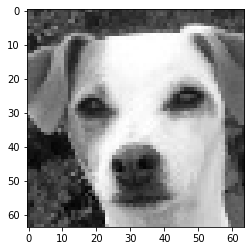

In [58]:
print("Original image 9:")
show_image(Xtrain,9)



PCA image 9:


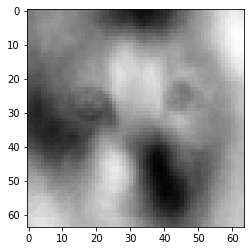

In [59]:
print("PCA image 9:")
show_image(Xtrain_pca_T,9)



Original image 10:


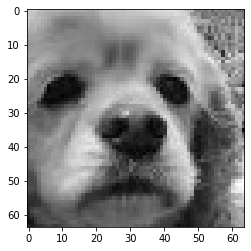

In [60]:
print("Original image 10:")
show_image(Xtrain,10)



PCA image 10:


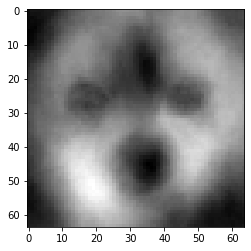

In [61]:
print("PCA image 10:")
show_image(Xtrain_pca_T,10)

In [19]:
#This function takes in a training data matrix Xtrain, training
#label vector ytrain and uses them to compute the PCA basis. 
#It also takes in a data matrix Xrun and a dimension k
#and uses the top-k vectors in the PCA basis to reduce the 
#dimension of Xtrain and Xrun. Finally, it uses the reduced data
#as inputs to the linear_regression function to produce 
#a vector of label guesses yguess.

def pca_regression(Xtrain,ytrain,Xrun, dim):
    
    
    Xmatrix = np.concatenate((Xtrain, Xrun), axis = 0)

    Xtrain_PCA = pca(Xmatrix.T)[0:len(Xtrain),0:dim] #reduce xtrain using PCA
    Xrun_PCA = pca(Xmatrix.T)[len(Xtrain):,0:dim] #reduce xrun using PCA

    yguess = linear_regression(Xtrain_PCA, ytrain, Xrun_PCA) #linear regression on reduced dimention matrices
    
    
    return yguess

In [21]:
X, y = read_data()
#split the data into train and test using given percentages

Xtrain, ytrain, Xtest, ytest = split_data(X,y,20)

print("dim = 10")
yguess_train_test = pca_regression(Xtrain, ytrain, Xtest, 10)
yguess_test_test = pca_regression(Xtest, ytest, Xtest, 10)
yguess_train_train = pca_regression(Xtrain, ytrain, Xtrain, 10)
yguess_test_train = pca_regression(Xtest, ytest, Xtrain, 10)

print("10- Train v. test accuracy: ", calculate_accuracy(ytest, yguess_train_test))
print("10- Test v. test accuracy: ", calculate_accuracy(ytest, yguess_test_test))
print("10- Train v. train accuracy: ", calculate_accuracy(ytrain, yguess_train_train))
print("10- Test v. train accuracy: ", calculate_accuracy(ytrain, yguess_test_train))

print("dim = 20")
yguess_train_test = pca_regression(Xtrain, ytrain, Xtest, 20)
yguess_test_test = pca_regression(Xtest, ytest, Xtest, 20)
yguess_train_train = pca_regression(Xtrain, ytrain, Xtrain, 20)
yguess_test_train = pca_regression(Xtest, ytest, Xtrain, 20)

print("20- Train v. test accuracy: ", calculate_accuracy(ytest, yguess_train_test))
print("20- Test v. test accuracy: ", calculate_accuracy(ytest, yguess_test_test))
print("20- Train v. train accuracy: ", calculate_accuracy(ytrain, yguess_train_train))
print("20- Test v. train accuracy: ", calculate_accuracy(ytrain, yguess_test_train))

print("dim = 50")
yguess_train_test = pca_regression(Xtrain, ytrain, Xtest, 50)
yguess_test_test = pca_regression(Xtest, ytest, Xtest, 50)
yguess_train_train = pca_regression(Xtrain, ytrain, Xtrain, 50)
yguess_test_train = pca_regression(Xtest, ytest, Xtrain, 50)

print("50- Train v. test accuracy: ", calculate_accuracy(ytest, yguess_train_test))
print("50- Test v. test accuracy: ", calculate_accuracy(ytest, yguess_test_test))
print("50- Train v. train accuracy: ", calculate_accuracy(ytrain, yguess_train_train))
print("50- Test v. train accuracy: ", calculate_accuracy(ytrain, yguess_test_train))

print("dim = 100")
yguess_train_test = pca_regression(Xtrain, ytrain, Xtest, 100)
yguess_test_test = pca_regression(Xtest, ytest, Xtest, 100)
yguess_train_train = pca_regression(Xtrain, ytrain, Xtrain, 100)
yguess_test_train = pca_regression(Xtest, ytest, Xtrain, 100)

print("100- Train v. test accuracy: ", calculate_accuracy(ytest, yguess_train_test))
print("100- Test v. test accuracy: ", calculate_accuracy(ytest, yguess_test_test))
print("100- Train v. train accuracy: ", calculate_accuracy(ytrain, yguess_train_train))
print("100- Test v. train accuracy: ", calculate_accuracy(ytrain, yguess_test_train))



dim = 10
10- Train v. test accuracy:  85.5
10- Test v. test accuracy:  85.25
10- Train v. train accuracy:  86.0625
10- Test v. train accuracy:  85.4375
dim = 20
20- Train v. test accuracy:  87.25
20- Test v. test accuracy:  87.0
20- Train v. train accuracy:  89.0625
20- Test v. train accuracy:  87.3125
dim = 50
50- Train v. test accuracy:  90.25
50- Test v. test accuracy:  93.0
50- Train v. train accuracy:  92.3125
50- Test v. train accuracy:  89.6875
dim = 100
100- Train v. test accuracy:  90.75
100- Test v. test accuracy:  96.25
100- Train v. train accuracy:  94.3125
100- Test v. train accuracy:  89.75


In [2]:
import os #trying to make sure I'm in the correct directory

cwd = os.getcwd()

In [3]:
print(cwd)

/Users/cheffbcookin/Desktop/EK 381/pet_classification_dataset


In [6]:
pip --version

pip 19.2.3 from /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pip (python 3.8)
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install matplotlib

     |████████████████████████████████| 12.5MB 1.9MB/s 
     |████████████████████████████████| 15.2MB 10.9MB/s 
     |████████████████████████████████| 61kB 15.2MB/s 
     |████████████████████████████████| 71kB 20.9MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --upgrade pip

     |████████████████████████████████| 1.4MB 1.5MB/s 
  Found existing installation: pip 19.2.3
    Uninstalling pip-19.2.3:
      Successfully uninstalled pip-19.2.3
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install scikit-image

     |████████████████████████████████| 26.2 MB 22.8 MB/s 
     |████████████████████████████████| 28.8 MB 102.0 MB/s 
     |████████████████████████████████| 4.3 MB 23.8 MB/s 
     |████████████████████████████████| 3.3 MB 43.3 MB/s 
     |████████████████████████████████| 2.2 MB 11.6 MB/s 
     |████████████████████████████████| 1.6 MB 37.0 MB/s
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  NOTE: The current PATH contains path(s) starting with `~`, which may not be expanded by all applications.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install np

    Running setup.py install for np ... done
Note: you may need to restart the kernel to use updated packages.
